# Modeling 4
* Scale numerical features.
* Aggregate `transcript_id`, `transcript_position`, `nucleotides` using mean.
* Seperate `nucleotides` and use as features.
* Use `transcript_position` as features.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import xgboost as xgb

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import \
    LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import \
    StratifiedKFold, GridSearchCV
from sklearn.metrics import \
    accuracy_score, precision_score, recall_score, f1_score, \
    roc_curve, precision_recall_curve, \
    roc_auc_score, average_precision_score, \
    confusion_matrix, classification_report
from xgboost import XGBClassifier 
from math import floor

%matplotlib inline
plt.style.use('default')
warnings.filterwarnings("ignore")

DATA_DIR = "../data"  # save data locally for faster read / write
MODEL_DIR = os.path.join(os.path.expanduser('~'), 'studies/ProjectStorage/tanyeejet/models') # models' size not as big as data, save in s3 for everyone 

In [2]:
df = pd.read_csv(os.path.join(DATA_DIR, "df3_scaled.csv"))

In [3]:
df.head()

,transcript_id,transcript_position,nucleotides,0,1,2,3,4,5,6,7,8,gene_id,label
0,ENST00000000233,244,AAGACCA,0.011239,0.009548,0.649123,0.117647,0.050283,0.578164,0.075390,0.058543,0.281707,ENSG00000004059,0
1,ENST00000000233,244,AAGACCA,0.039294,0.011831,0.649123,0.049729,0.022461,0.627792,0.085258,0.033525,0.242683,ENSG00000004059,0
2,ENST00000000233,244,AAGACCA,0.025266,0.018581,0.448622,0.087575,0.058051,0.602978,0.032761,0.010845,0.226829,ENSG00000004059,0
3,ENST00000000233,244,AAGACCA,0.019605,0.009548,0.649123,0.048702,0.024112,0.677419,0.032761,0.019819,0.236585,ENSG00000004059,0
4,ENST00000000233,244,AAGACCA,0.042082,0.013725,0.586466,0.007335,0.018917,0.665012,0.111901,0.038148,0.258537,ENSG00000004059,0


In [4]:
df.dtypes

transcript_id           object
transcript_position      int64
nucleotides             object
0                      float64
1                      float64
2                      float64
3                      float64
4                      float64
5                      float64
6                      float64
7                      float64
8                      float64
gene_id                 object
label                    int64
dtype: object

In [5]:
df = df.astype({'transcript_position': 'str'})

In [6]:
# designate data types
# df['label'] = df['label'].astype(str)
# df['transcript_position'] = df['transcript_position'].astype(str)

In [7]:
df.dtypes

transcript_id           object
transcript_position     object
nucleotides             object
0                      float64
1                      float64
2                      float64
3                      float64
4                      float64
5                      float64
6                      float64
7                      float64
8                      float64
gene_id                 object
label                    int64
dtype: object

In [8]:
# groupby and agg using mean 
df2 = df.groupby(by = ['transcript_id', 'transcript_position', 'nucleotides']).mean()
df2.reset_index(inplace=True)
df2.head()

,transcript_id,transcript_position,nucleotides,0,1,2,3,4,5,6,7,8,label
0,ENST00000000233,244,AAGACCA,0.055809,0.020057,0.632866,0.056574,0.035630,0.626719,0.056097,0.023120,0.238662,0.0
1,ENST00000000233,261,CAAACTG,0.041822,0.015164,0.457160,0.037795,0.015452,0.403096,0.059703,0.015667,0.405984,0.0
2,ENST00000000233,316,GAAACAG,0.049941,0.013824,0.404457,0.042214,0.017473,0.292147,0.058172,0.010612,0.345906,0.0
3,ENST00000000233,332,AGAACAT,0.075716,0.030996,0.703697,0.051139,0.013863,0.278368,0.043828,0.011424,0.343341,0.0
4,ENST00000000233,368,AGGACAA,0.076394,0.030699,0.560454,0.072020,0.028289,0.577600,0.082485,0.022431,0.294863,0.0


In [9]:
df2.shape

(121838, 13)

In [10]:
# seperate nucleotides
tmp = df2['nucleotides'].str.split(pat="", expand=True)
tmp.drop(columns=[tmp.columns[0], tmp.columns[-1]], inplace=True)
tmp = tmp.add_prefix("p")
tmp = pd.get_dummies(tmp)
df3 = pd.concat([df2, tmp], axis=1)

In [11]:
df3.head()

,transcript_id,transcript_position,nucleotides,0,1,2,3,4,5,6,...,p3_G,p4_A,p5_C,p6_A,p6_C,p6_T,p7_A,p7_C,p7_G,p7_T
0,ENST00000000233,244,AAGACCA,0.055809,0.020057,0.632866,0.056574,0.035630,0.626719,0.056097,...,1,1,1,0,1,0,1,0,0,0
1,ENST00000000233,261,CAAACTG,0.041822,0.015164,0.457160,0.037795,0.015452,0.403096,0.059703,...,0,1,1,0,0,1,0,0,1,0
2,ENST00000000233,316,GAAACAG,0.049941,0.013824,0.404457,0.042214,0.017473,0.292147,0.058172,...,0,1,1,1,0,0,0,0,1,0
3,ENST00000000233,332,AGAACAT,0.075716,0.030996,0.703697,0.051139,0.013863,0.278368,0.043828,...,0,1,1,1,0,0,0,0,0,1
4,ENST00000000233,368,AGGACAA,0.076394,0.030699,0.560454,0.072020,0.028289,0.577600,0.082485,...,1,1,1,1,0,0,1,0,0,0


In [12]:
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
df3[['transcript_position']] = scaler.fit_transform(df3[['transcript_position']])

In [13]:
df3.head()

,transcript_id,transcript_position,nucleotides,0,1,2,3,4,5,6,...,p3_G,p4_A,p5_C,p6_A,p6_C,p6_T,p7_A,p7_C,p7_G,p7_T
0,ENST00000000233,0.012869,AAGACCA,0.055809,0.020057,0.632866,0.056574,0.035630,0.626719,0.056097,...,1,1,1,0,1,0,1,0,0,0
1,ENST00000000233,0.013777,CAAACTG,0.041822,0.015164,0.457160,0.037795,0.015452,0.403096,0.059703,...,0,1,1,0,0,1,0,0,1,0
2,ENST00000000233,0.016714,GAAACAG,0.049941,0.013824,0.404457,0.042214,0.017473,0.292147,0.058172,...,0,1,1,1,0,0,0,0,1,0
3,ENST00000000233,0.017568,AGAACAT,0.075716,0.030996,0.703697,0.051139,0.013863,0.278368,0.043828,...,0,1,1,1,0,0,0,0,0,1
4,ENST00000000233,0.019491,AGGACAA,0.076394,0.030699,0.560454,0.072020,0.028289,0.577600,0.082485,...,1,1,1,1,0,0,1,0,0,0


## Train test split

In [14]:
X = df3[['transcript_position', '0', '1', '2', '3', '4', '5', '6', '7', '8', 'p1_A', 'p1_C', 'p1_G', 'p1_T', 'p2_A', 'p2_G', 'p2_T', 'p3_A', 'p3_G', 'p4_A', 'p5_C', 'p6_A', 'p6_C', 'p6_T', 'p7_A', 'p7_C', 'p7_G', 'p7_T']]
y = df3['label']

In [15]:
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Collect models and results

In [16]:
models = []
roc_aucs = []
pr_aucs = []
precisions = []
recalls = []
f1s = []
roc_curves = []
pr_curves = []

## Naive Bayes

In [17]:
%%time

model = GaussianNB()
model.fit(Xtr, ytr)

CPU times: user 59 ms, sys: 17 ms, total: 76 ms
Wall time: 75.3 ms


GaussianNB()

In [18]:
# with open(os.path.join(MODEL_DIR, 'nb4.pickle'), 'wb') as f:
#     pickle.dump(model, f)

In [19]:
with open(os.path.join(MODEL_DIR, 'nb4.pickle'), 'rb') as f:
    model = pickle.load(f)
    print(model)

GaussianNB()


In [20]:
yhat_probs = model.predict_proba(Xte)
yhat = model.predict(Xte)
yhat1_probs = yhat_probs[:, 1]

In [21]:
models.append('nb')
roc_aucs.append(roc_auc_score(yte, yhat1_probs))
pr_aucs.append(average_precision_score(yte, yhat))
precisions.append(precision_score(yte, yhat))
recalls.append(recall_score(yte, yhat))
f1s.append(f1_score(yte, yhat))
roc_curves.append(roc_curve(yte, yhat1_probs))
pr_curves.append(precision_recall_curve(yte, yhat1_probs))

## XGBoost

In [22]:
from collections import Counter

# count examples in each class
count_label = Counter(ytr)
# estimate scale_pos_weight value
estimate = count_label[0] / count_label[1]
print('Estimate: %.3f' % estimate)

Estimate: 21.253


In [23]:
from math import ceil

model = XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight = ceil(estimate),
    max_delta_step=1,
    seed=42,
    verbosity=1
)

In [24]:
# model.fit(Xtr, ytr)

In [25]:
# model.save_model(os.path.join(MODEL_DIR, 'xgb4.model'))

In [26]:
# model = XGBClassifier()  # init model
model.load_model(os.path.join(MODEL_DIR, 'xgb4.model'))
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=1, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


In [27]:
# xgb.plot_tree(model, num_trees=2)
# xgb.to_graphviz(model, num_trees=2)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

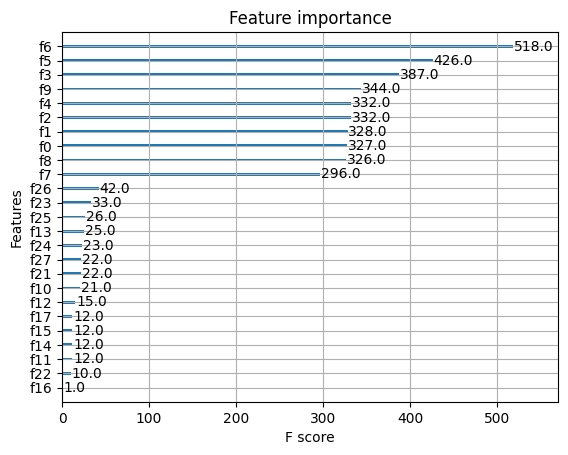

In [28]:
xgb.plot_importance(model)

In [29]:
yhat_probs = model.predict_proba(Xte, iteration_range=(0, model.best_iteration + 1))
yhat = model.predict(Xte, iteration_range=(0, model.best_iteration + 1))
yhat1_probs = yhat_probs[:, 1]

In [30]:
# with open(os.path.join(MODEL_DIR, 'xgb4_yhat_probs.pickle'), 'wb') as f:
#     pickle.dump(yhat_probs, f)
    
# with open(os.path.join(MODEL_DIR, 'xgb4_yhat.pickle'), 'wb') as f:
#     pickle.dump(yhat, f)

In [31]:
models.append('xgb')
roc_aucs.append(roc_auc_score(yte, yhat1_probs))
pr_aucs.append(average_precision_score(yte, yhat))
precisions.append(precision_score(yte, yhat))
recalls.append(recall_score(yte, yhat))
f1s.append(f1_score(yte, yhat))
roc_curves.append(roc_curve(yte, yhat1_probs))
pr_curves.append(precision_recall_curve(yte, yhat1_probs))

## Evaluate models

nb: ROC AUC = 0.798
nb: PR AUC = 0.094
nb: Precision = 0.171
nb: Recall = 0.391
nb: F1 = 0.238
xgb: ROC AUC = 0.892
xgb: PR AUC = 0.194
xgb: Precision = 0.252
xgb: Recall = 0.720
xgb: F1 = 0.374


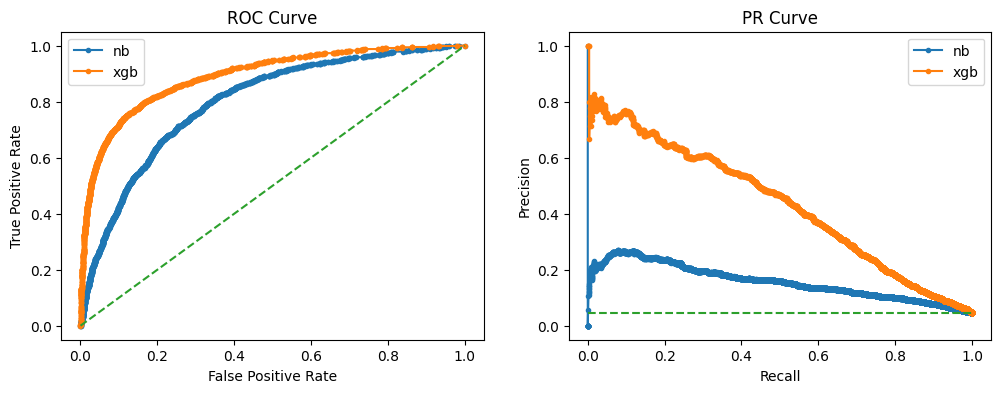

In [32]:
plt.figure(figsize=(12, 4))
random_yhat_probs = np.zeros(len(yte))
random_fpr, random_tpr, _ = roc_curve(yte, random_yhat_probs)

# relevant metrics
# roc_auc_score(yte, yhat1_probs)
# average_precision_score(yte, yhat)
# precision_score(yte, yhat)
# recall_score(yte, yhat)
# f1_score(yte, yhat)
# roc_curve(yte, yhat1_probs)
# precision_recall_curve(yte, yhat1_probs)

for _model, _roc_auc, _pr_auc, _precision, _recall, _f1, _roc_curve, _pr_curve in zip(models, roc_aucs, pr_aucs, precisions, recalls, f1s, roc_curves, pr_curves):
    print(f'{_model}: ROC AUC = {_roc_auc:.3f}')
    print(f'{_model}: PR AUC = {_pr_auc:.3f}')
    print(f'{_model}: Precision = {_precision:.3f}')
    print(f'{_model}: Recall = {_recall:.3f}')
    print(f'{_model}: F1 = {_f1:.3f}')


    # ROC
    fpr, tpr, _ = _roc_curve

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, marker='.', label=_model)

    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # PR
    precision, recall, _ = _pr_curve

    plt.subplot(1, 2, 2)
    no_skill = len(yte[yte==1]) / len(yte)
    plt.plot(recall, precision, marker='.', label=_model)

    plt.title('PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

plt.subplot(1, 2, 1)
plt.plot(random_fpr, random_tpr, linestyle='--', label='Random')
plt.subplot(1, 2, 2)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Random')
plt.show()

## Test training and prediction from script

In [35]:
!python3 ../scripts/train_xgb.py -d ../data/data.json -l ../data/data.info -s ../out.model

[INFO] Preprocessing data...
[INFO] Initializing model...
[INFO] Fitting model...
[INFO] Saving model...
[INFO] Done.


In [39]:
!python3 ../scripts/predict_xgb.py -d ../data/data.json -m ../out.model -s ../dataset0.csv

[INFO] Preprocessing data...
[INFO] Loading model...
[INFO] Running inference...
[INFO] Saving predictions...
../scripts/predict_xgb.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res.rename(columns={"transcript_position0": "transcript_position"}, inplace=True)
[INFO] Done.
